# Improved Model

In [1]:
import pandas as pd
import numpy as np
import json, joblib, shap
import matplotlib.pyplot as plt

from pathlib import Path
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, make_scorer, average_precision_score,
    recall_score, fbeta_score, PrecisionRecallDisplay, RocCurveDisplay
)


c:\Users\brt.rtawil\Documents\EY\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
acc_sub = pd.read_csv('../eda/lc_accepted_outputs/accepted_subset_clean.csv')

## Prepare features & split (same target, balanced class weights)

In [3]:
target = "default_flag"

model_feats = [c for c in [
    "loan_amnt","int_rate","fico_range_low","fico_range_high",
    "annual_inc","dti","revol_util","emp_length_num","term_num",
    "grade","sub_grade","home_ownership","verification_status","purpose"
] if c in acc_sub.columns]

num_cols = [c for c in ["loan_amnt","int_rate","fico_range_low","fico_range_high","annual_inc",
                        "dti","revol_util","emp_length_num","term_num"] if c in model_feats]
cat_cols = [c for c in ["grade","sub_grade","home_ownership","verification_status","purpose"] if c in model_feats]

X = acc_sub[model_feats].copy()
y = acc_sub[target].astype(int)

# Numeric coercion + simple imputations
for c in num_cols:
    X[c] = pd.to_numeric(X[c], errors="coerce")
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

# Categorical: fill and cast to string (stable OHE)
for c in cat_cols:
    X[c] = X[c].astype("object").fillna("Unknown")


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

pre = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols)
])


## XGBoost pipeline + hyperparameter search optimized for PR-AUC

In [5]:
# Handle imbalance: scale_pos_weight = (neg/pos) in the training fold
pos = y_train.sum()
neg = (y_train == 0).sum()
scale_pos_weight = max(1.0, neg / max(1, pos))

xgb = XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    eval_metric="aucpr",
    n_estimators=400,
    learning_rate=0.06,
    max_depth=4,
    min_child_weight=5,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    reg_alpha=0.0,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

pipe = Pipeline([
    ("pre", pre),
    ("clf", xgb)
])

param_dist = {
    "clf__n_estimators": [300, 400, 600],
    "clf__learning_rate": [0.03, 0.05, 0.06, 0.08],
    "clf__max_depth": [3, 4, 5],
    "clf__min_child_weight": [3, 5, 8],
    "clf__subsample": [0.7, 0.85, 1.0],
    "clf__colsample_bytree": [0.7, 0.85, 1.0],
    "clf__reg_lambda": [0.5, 1.0, 2.0],
    "clf__reg_alpha": [0.0, 0.5, 1.0],
}

# 1) stronger stratification + more folds to ensure positives in each split
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2) defensive scorer: if a fold has only one class, return 0.0 instead of NaN
def safe_ap(y_true, y_score):
    if len(np.unique(y_true)) < 2:
        return 0.0
    return average_precision_score(y_true, y_score)

pr_auc_scorer = make_scorer(
    safe_ap,
    response_method="predict_proba",  # new API replaces needs_proba
    greater_is_better=True
)

# 3) during search, raise on errors to catch NaN preds quickly
search = RandomizedSearchCV(
    pipe, param_distributions=param_dist, n_iter=20,
    scoring=pr_auc_scorer, cv=cv, n_jobs=-1, verbose=1,
    random_state=42, error_score="raise"
)

# 4) XGB stability tweaks (before search)
xgb.set_params(
    max_delta_step=1,           # helps with class imbalance stability
    predictor="cpu_predictor",  # deterministic CPU inference
    monotone_constraints=None   # ensure not mis-set
)

search.fit(X_train, y_train)

best_model = search.best_estimator_
print("Best PR-AUC (CV):", search.best_score_)
print("Best params:", search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\brt.rtawil\Documents\EY\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:07:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best PR-AUC (CV): 0.1760530665791598
Best params: {'clf__subsample': 0.85, 'clf__reg_lambda': 0.5, 'clf__reg_alpha': 1.0, 'clf__n_estimators': 400, 'clf__min_child_weight': 8, 'clf__max_depth': 3, 'clf__learning_rate': 0.08, 'clf__colsample_bytree': 0.85}


##  Evaluation: rare-event metrics + curves + thresholding

{'ROC_AUC': 0.7474, 'PR_AUC': 0.1676, 'Precision@0.5': 0.1382, 'Recall@0.5': 0.6927, 'F1@0.5': 0.2305, 'Base rate (defaults)': np.float64(0.0687)}

Confusion @0.5:
 [[7932 3709]
 [ 264  595]]

Class report @0.5:
               precision    recall  f1-score   support

           0      0.968     0.681     0.800     11641
           1      0.138     0.693     0.230       859

    accuracy                          0.682     12500
   macro avg      0.553     0.687     0.515     12500
weighted avg      0.911     0.682     0.761     12500



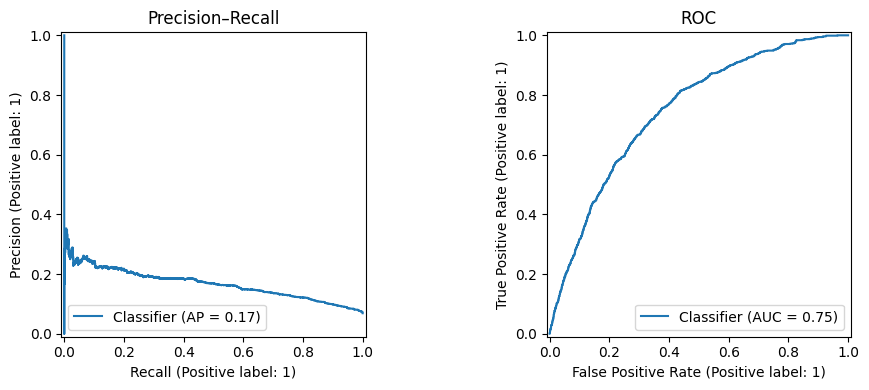


Best F1 threshold=0.630 -> precision=0.183, recall=0.435, F1=0.258


In [6]:
p_test = best_model.predict_proba(X_test)[:,1]
y_pred_05 = (p_test >= 0.5).astype(int)

# Aggregate metrics
roc_auc = roc_auc_score(y_test, p_test)
pr_auc  = average_precision_score(y_test, p_test)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_05, average="binary", zero_division=0)
print({
    "ROC_AUC": round(roc_auc, 4),
    "PR_AUC": round(pr_auc, 4),
    "Precision@0.5": round(prec, 4),
    "Recall@0.5": round(rec, 4),
    "F1@0.5": round(f1, 4),
    "Base rate (defaults)": round(y_test.mean(), 4),
})
print("\nConfusion @0.5:\n", confusion_matrix(y_test, y_pred_05))
print("\nClass report @0.5:\n", classification_report(y_test, y_pred_05, digits=3))

# Curves
fig = plt.figure(figsize=(10,4))
ax1 = plt.subplot(1,2,1)
PrecisionRecallDisplay.from_predictions(y_test, p_test, ax=ax1)
ax1.set_title("Precision–Recall")

ax2 = plt.subplot(1,2,2)
RocCurveDisplay.from_predictions(y_test, p_test, ax=ax2)
ax2.set_title("ROC")
plt.tight_layout(); plt.show()

# Find threshold that maximizes F1 (you can switch to F_beta to favor recall)
ths = np.linspace(0.01, 0.99, 99)
scores = []
for t in ths:
    yp = (p_test >= t).astype(int)
    pr, rc, f1t, _ = precision_recall_fscore_support(y_test, yp, average="binary", zero_division=0)
    scores.append((t, pr, rc, f1t))
best_t, best_p, best_r, best_f1 = max(scores, key=lambda x: x[3])
print(f"\nBest F1 threshold={best_t:.3f} -> precision={best_p:.3f}, recall={best_r:.3f}, F1={best_f1:.3f}")


this model is **meaningfully better** especially at cutting false alarms, though it still needs **threshold tuning** for business value.

* **Ranking power:**

  * **ROC AUC:** 0.747 → up from 0.697 (**+0.05**).
  * **PR AUC:** 0.168 → up from 0.132 (**+0.036**).
    Better separation where it counts (rare defaults).

* **At threshold 0.5 (same operating point):**

  * **Precision:** 0.138 → up from 0.108 (**+3.0 pp**). That’s **~2.0×** the base rate (6.87%) vs ~1.56× before.
  * **Recall:** 0.693 → ~flat (0.700 before). You’re catching almost the same share of defaulters.
  * **Specificity:** **0.681** (FPR **0.319**) → up from 0.571 (FPR 0.429).
  * **Accuracy:** **0.682** → up from 0.580.

* **Confusion matrix impact @0.5:**

  * **FPs drop from 4,990 → 3,709** (−1,281 good borrowers wrongly flagged).
  * **TPs roughly flat:** 601 → 595 (−6).
  * **Predicted positives (alerts) fall:** 5,591 → **4,304** (−1,287 workload).

So you keep nearly the same **recall**, **double the lift** over base rate in precision, and **slash false positives**. That’s a clear operational win.

### Business read

If you this version **rejects ~1.3k fewer good loans** for essentially the same defaults caught. If you “manual review flagged,” your review queue drops ~23% with **higher hit rate** lower ops cost.

In [7]:
# --- 5) Top-K (review bands) with tie-aware selection ---

def topk_report_tieaware(probs, y_true, k_list=[0.05, 0.10, 0.20]):
    idx = np.argsort(-probs, kind="mergesort")
    n = len(probs)
    reports = {}
    for k in k_list:
        kcount = max(1, int(round(k*n)))
        sel_idx = idx[:kcount]
        y_hat = np.zeros(n, dtype=int); y_hat[sel_idx] = 1
        cm = confusion_matrix(y_true, y_hat)
        prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_hat, average="binary", zero_division=0)
        thr = float(probs[sel_idx[-1]])
        reports[f"top_{int(k*100)}pct"] = {
            "threshold": thr, "precision": float(prec), "recall": float(rec),
            "f1": float(f1), "confusion_matrix": cm.tolist()
        }
    return reports

topk = topk_report_tieaware(p_test, y_test, [0.05, 0.10, 0.20])
topk


{'top_5pct': {'threshold': 0.7352205514907837,
  'precision': 0.2208,
  'recall': 0.16065192083818394,
  'f1': 0.18598382749326145,
  'confusion_matrix': [[11154, 487], [721, 138]]},
 'top_10pct': {'threshold': 0.6819370985031128,
  'precision': 0.1944,
  'recall': 0.2828870779976717,
  'f1': 0.23044096728307253,
  'confusion_matrix': [[10634, 1007], [616, 243]]},
 'top_20pct': {'threshold': 0.6024234890937805,
  'precision': 0.1688,
  'recall': 0.4912689173457509,
  'f1': 0.2512652575171182,
  'confusion_matrix': [[9563, 2078], [437, 422]]}}

* Actual defaulters (positives): **859** → **base rate ≈ 6.87%**

### Top 5% review (k=0.05)

* Threshold ≈ **0.735**
* You review **625** cases (5% of 12,500)
* **Precision 22.1%** → ~**1 in 4.5** flagged actually default
* **Recall 16.1%** → it catch **138/859 ≈ 16%** of all defaulters
* **Lift ≈ 3.2×** over baseline (22.1% / 6.87%)
* Errors/resources: **FP=487**, **FN=721**

**When to use:** very tight review capacity; it accept missing most defaulters while focusing on the highest-risk sliver.

### Top 10% review (k=0.10)

* Threshold ≈ **0.682**
* You review **1,250** cases
* **Precision 19.4%** → ~**1 in 5.1** flagged actually default
* **Recall 28.3%** → it catch **243/859 ≈ 28%** of defaulters
* **Lift ≈ 2.8×**
* Errors/resources: **FP=1,007**, **FN=616**

**When to use:** moderate capacity; better coverage of defaulters with a small hit to precision vs 5%.

### Top 20% review (k=0.20)

* Threshold ≈ **0.602**
* You review **2,500** cases
* **Precision 16.9%** → ~**1 in 5.9** flagged actually default
* **Recall 49.1%** → it catch **422/859 ≈ 49%** of defaulters
* **Lift ≈ 2.5×**
* Errors/resources: **FP=2,078**, **FN=437**

**When to use:** higher capacity or when **missing defaulters is very costly**; it capture half of all defaulters.

### Big picture trade-off

* As it widen the review band (5% → 20%), **recall rises** (16% → 49%) and **precision falls** (22% → 17%).
* **F1** improves with k and is highest at **20%** (≈0.251), meaning a better balance of precision/recall overall.
* The **thresholds** (0.735 / 0.682 / 0.602) are the cutoffs you can apply directly to new scores to reproduce each operating point without recomputing top-k.


## Feature Importance + SHAP on transformed features

grade_A                             0.103589
grade_C                             0.051005
int_rate                            0.050678
grade_D                             0.049781
grade_B                             0.035786
home_ownership_MORTGAGE             0.029378
fico_range_high                     0.027157
verification_status_Verified        0.024689
sub_grade_C2                        0.022928
sub_grade_E5                        0.020699
home_ownership_RENT                 0.019867
sub_grade_C3                        0.019675
verification_status_Not Verified    0.018170
sub_grade_B5                        0.018045
sub_grade_C4                        0.017154
sub_grade_D4                        0.016485
sub_grade_A1                        0.016329
sub_grade_B1                        0.016143
grade_E                             0.014380
annual_inc                          0.014340
loan_amnt                           0.014280
term_num                            0.013957
grade_G   

 98%|===================| 12225/12500 [00:40<00:00]        

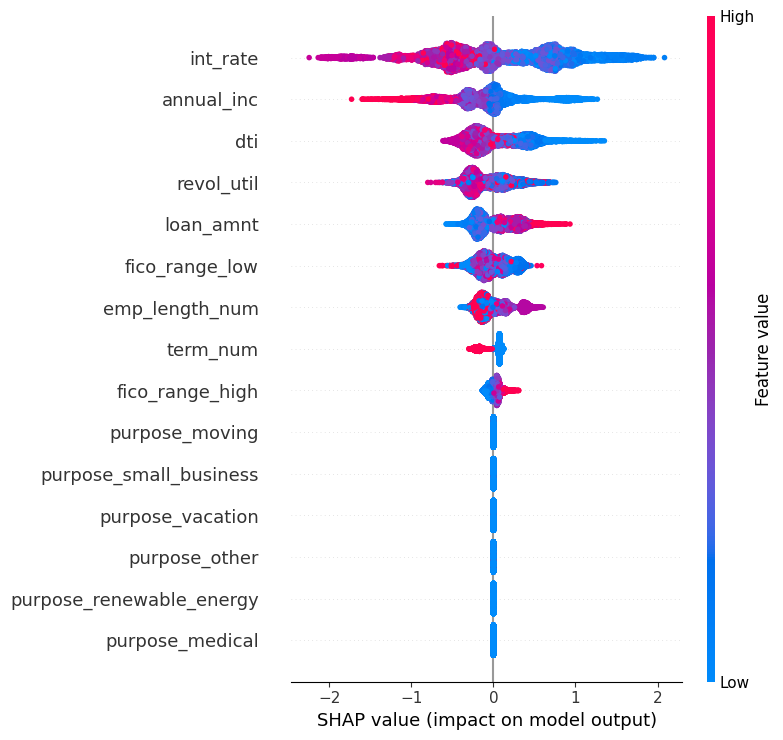

In [8]:
# Map OHE-expanded feature names to XGBoost importances (gain)
ohe = best_model.named_steps["pre"].transformers_[1][1] if len(cat_cols) else None
cat_names = list(ohe.get_feature_names_out(cat_cols)) if ohe is not None else []
feature_names = num_cols + cat_names

clf = best_model.named_steps["clf"]

# XGBoost built-in importances (gain) aligned to transformed columns
importances = pd.Series(clf.feature_importances_, index=feature_names).sort_values(ascending=False)
display(importances.head(25))


X_train_trans = best_model.named_steps["pre"].transform(X_train)
X_test_trans  = best_model.named_steps["pre"].transform(X_test)

# Densify if sparse
if hasattr(X_train_trans, "toarray"):
    X_train_trans = X_train_trans.toarray()
    X_test_trans  = X_test_trans.toarray()

# Use a small background set for performance
rng = np.random.RandomState(42)
bg_idx = rng.choice(X_train_trans.shape[0], size=min(1000, X_train_trans.shape[0]), replace=False)
background = X_train_trans[bg_idx]

explainer = shap.TreeExplainer(clf, data=background, feature_names=feature_names)
sv = explainer.shap_values(X_test_trans)  # for XGBoost binary, returns array (no list)
# Global summary: which features drive default risk most (by |SHAP|)
shap.summary_plot(sv, X_test_trans, feature_names=feature_names, max_display=15, show=True)


* **XGBoost gain importances:** dominated by **grade/sub-grade** dummies, plus some key numerics (int_rate, FICO, income, term, revol_util). These show which splits the trees used most, but not effect direction.

* **SHAP summary:** highlights the **true drivers of prediction** with direction:

  * **Higher → more risk:** interest rate, DTI, revolving utilization, loan amount, longer term, risky purposes (small_business, moving, vacation).
  * **Higher → less risk:** income, FICO, employment length.

* **Difference:** Grades/sub-grades look huge in gain but less dominant in SHAP, since they encode LC’s own risk tiers. SHAP shows the raw financial features are the real levers.

* **Takeaway:**

  * Use SHAP for **interpretability & actionable insights** (e.g., focusing on income, DTI, term).
  * Grades/sub-grades improve **prediction**, but risk circularity—consider testing models with and without them.

👉 In short: **default risk rises with high rates, high debt, high utilization, big loans, long terms, and risky purposes; it falls with strong income, high FICO, and stability.**



## Save the Model

In [9]:
OUTDIR = Path("./saved_models")
model_path = OUTDIR / f"xgb_1.joblib"
joblib.dump(best_model, model_path)

meta = {
    "selected": 'XGBClassifier_1', 
    "report": {
        "test_metrics": {
            "ROC_AUC": round(roc_auc, 4),
            "PR_AUC": round(pr_auc, 4),
            "Precision@0.5": round(prec, 4),
            "Recall@0.5": round(rec, 4),
            "F1@0.5": round(f1, 4),
            "Base rate (defaults)": round(y_test.mean(), 4),
        },
        "topk": topk
    },
    "features": model_feats,
    "num_features": num_cols,
    "cat_features": cat_cols,
    "model_params": best_model.named_steps["clf"].get_params(),
    "train_size": int(X_train.shape[0]),
    "test_size": int(X_test.shape[0]),
    "train_date": pd.Timestamp.now().isoformat(),
}
with open(OUTDIR / "xgb_1.json", "w") as f:
    json.dump(meta, f, indent=2)

print(f"\nSaved best model to: {model_path}")
print(f"Saved metadata to:   {OUTDIR / 'xgb_1.json'}")


Saved best model to: saved_models\xgb_1.joblib
Saved metadata to:   saved_models\xgb_1.json


## Test the Model with an example

In [10]:
example = pd.DataFrame([{
    "loan_amnt": 15000,
    "int_rate": 13.5,
    "fico_range_low": 680,  
    "fico_range_high": 700,
    "annual_inc": 85000,
    "dti": 18.0,
    "revol_util": 30.0,
    "emp_length_num": 5,
    "term_num": 36,
    "grade": "B",
    "sub_grade": "B3",
    "home_ownership": "MORTGAGE",
    "verification_status": "Verified",
    "purpose": "debt_consolidation"
}])
pred_prob = best_model.predict_proba(example)[:,1][0]
print(f"Example prediction (default prob.): {pred_prob:.4f}")

Example prediction (default prob.): 0.3685


# Goal Minimize false negative(catch as many future defaulters as possible)

## Prepare features & split (same target, balanced class weights)

In [11]:
RANDOM_STATE = 42
REVIEW_K = 0.20     # review budget: evaluate & select model by recall@K (e.g., 0.10 or 0.20)
BETA = 3            # Fβ for Option B (recall-heavy)

In [12]:
target = "default_flag"
model_feats = [c for c in [
    "loan_amnt","int_rate","fico_range_low","fico_range_high",
    "annual_inc","dti","revol_util","emp_length_num","term_num",
    "grade","sub_grade","home_ownership","verification_status","purpose"
] if c in acc_sub.columns]

num_cols = [c for c in ["loan_amnt","int_rate","fico_range_low","fico_range_high","annual_inc",
                        "dti","revol_util","emp_length_num","term_num"] if c in model_feats]
cat_cols = [c for c in ["grade","sub_grade","home_ownership","verification_status","purpose"] if c in model_feats]

X = acc_sub[model_feats].copy()
y = acc_sub[target].astype(int)

# Clean/impute minimal
for c in num_cols:
    X[c] = pd.to_numeric(X[c], errors="coerce")
X[num_cols] = X[num_cols].fillna(X[num_cols].median())
for c in cat_cols:
    X[c] = X[c].astype("object").fillna("Unknown")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

pre = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols)
])

## Train 2 XGB classifiers

### Tunes for recall@top-K directly (K=20%)
### Tunes for Fβ (β>1) to globally favor recall without fixing K.

Option A aligns training to the operational objective directly, Option B is a global recall-favoring backup

In [13]:
# Imbalance weight (fixed from training distribution)
pos = int(y_train.sum())
neg = int((y_train == 0).sum())
scale_pos_weight = max(1.0, neg / max(1, pos))

# Base classifier (will be copied by the CV search)
base_xgb = XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    eval_metric="aucpr",
    n_estimators=400,
    learning_rate=0.06,
    max_depth=4,
    min_child_weight=5,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    reg_alpha=0.0,
    scale_pos_weight=scale_pos_weight,
    max_delta_step=1,           # stability on rare positives
    predictor="cpu_predictor",
    random_state=RANDOM_STATE,
)

pipe = Pipeline([
    ("pre", pre),
    ("clf", base_xgb)
])

param_dist = {
    "clf__n_estimators": [300, 400, 600],
    "clf__learning_rate": [0.03, 0.05, 0.06, 0.08],
    "clf__max_depth": [3, 4, 5],
    "clf__min_child_weight": [3, 5, 8],
    "clf__subsample": [0.7, 0.85, 1.0],
    "clf__colsample_bytree": [0.7, 0.85, 1.0],
    "clf__reg_lambda": [0.5, 1.0, 2.0],
    "clf__reg_alpha": [0.0, 0.5, 1.0],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [14]:
# ----------------------------
# Scorers
# ----------------------------
def recall_at_topk(y_true, y_proba, k=REVIEW_K):
    n = len(y_proba)
    kcount = max(1, int(round(k*n)))
    idx = np.argsort(-y_proba, kind="mergesort")[:kcount]
    y_hat = np.zeros(n, dtype=int); y_hat[idx] = 1
    return recall_score(y_true, y_hat)

def make_topk_scorer(k=REVIEW_K):
    def _score(est, X, y):
        p = est.predict_proba(X)[:,1]
        # guard against degenerate folds (shouldn't happen with stratified k=5)
        if len(np.unique(y)) < 2:
            return 0.0
        return recall_at_topk(y, p, k=k)
    return _score

# Fβ (recall-heavy) scorer at default 0.5 threshold
fbeta_scorer = make_scorer(fbeta_score, beta=BETA)

topk_scorer = make_topk_scorer(k=REVIEW_K)

# Sanity: positives per fold (make sure no empty-positive folds)
for i, (_, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    print(f"CV Fold {i}: positives={int(y_train.iloc[val_idx].sum())}, size={len(val_idx)}")

CV Fold 1: positives=515, size=7500
CV Fold 2: positives=515, size=7500
CV Fold 3: positives=515, size=7500
CV Fold 4: positives=515, size=7500
CV Fold 5: positives=516, size=7500


## Train Option A (recall@K) & Option B (Fβ)

In [15]:
search_A = RandomizedSearchCV(
    pipe, param_distributions=param_dist, n_iter=20,
    scoring=topk_scorer, cv=cv, n_jobs=-1, verbose=1,
    random_state=RANDOM_STATE, error_score="raise"
)
search_A.fit(X_train, y_train)
model_A = search_A.best_estimator_
print("Option A (recall@K) best CV:", search_A.best_score_)
print("Option A params:", search_A.best_params_)

search_B = RandomizedSearchCV(
    pipe, param_distributions=param_dist, n_iter=20,
    scoring=fbeta_scorer, cv=cv, n_jobs=-1, verbose=1,
    random_state=RANDOM_STATE, error_score="raise"
)
search_B.fit(X_train, y_train)
model_B = search_B.best_estimator_
print("Option B (Fβ) best CV:", search_B.best_score_)
print("Option B params:", search_B.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\brt.rtawil\Documents\EY\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:09:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Option A (recall@K) best CV: 0.49028749905923086
Option A params: {'clf__subsample': 1.0, 'clf__reg_lambda': 0.5, 'clf__reg_alpha': 0.5, 'clf__n_estimators': 600, 'clf__min_child_weight': 8, 'clf__max_depth': 3, 'clf__learning_rate': 0.06, 'clf__colsample_bytree': 0.7}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\brt.rtawil\Documents\EY\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:10:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Option B (Fβ) best CV: 0.4873294211063476
Option B params: {'clf__subsample': 1.0, 'clf__reg_lambda': 1.0, 'clf__reg_alpha': 1.0, 'clf__n_estimators': 400, 'clf__min_child_weight': 5, 'clf__max_depth': 3, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.7}


## Evaluate both on the test set; pick best by recall@K (tie-break PR-AUC)

In [16]:
def eval_model(est, X_te, y_te, name="model", review_k=REVIEW_K):
    p = est.predict_proba(X_te)[:,1]
    yhat05 = (p >= 0.5).astype(int)

    roc = roc_auc_score(y_te, p)
    prc = average_precision_score(y_te, p)

    prec, rec, f1, _ = precision_recall_fscore_support(y_te, yhat05, average="binary", zero_division=0)
    cm = confusion_matrix(y_te, yhat05)

    # recall@K
    n = len(p); kcount = max(1, int(round(review_k*n)))
    idx = np.argsort(-p, kind="mergesort")[:kcount]
    yhatK = np.zeros(n, dtype=int); yhatK[idx] = 1
    precK, recK, f1K, _ = precision_recall_fscore_support(y_te, yhatK, average="binary", zero_division=0)
    thrK = float(np.min(p[idx]))

    report = {
        "name": name,
        "ROC_AUC": float(roc),
        "PR_AUC": float(prc),
        "Precision@0.5": float(prec),
        "Recall@0.5": float(rec),
        "F1@0.5": float(f1),
        "Confusion@0.5": cm.tolist(),
        f"Precision@top_{int(review_k*100)}%": float(precK),
        f"Recall@top_{int(review_k*100)}%": float(recK),
        f"F1@top_{int(review_k*100)}%": float(f1K),
        f"Threshold@top_{int(review_k*100)}%": thrK,
    }
    return report, p

rep_A, pA = eval_model(model_A, X_test, y_test, name="OptionA_recall@K")
rep_B, pB = eval_model(model_B, X_test, y_test, name="OptionB_Fbeta")

print("\nOption A test report:\n", json.dumps(rep_A, indent=2))
print("\nOption B test report:\n", json.dumps(rep_B, indent=2))

# Choose best by highest recall@K, tie-break by PR_AUC
keyA = rep_A[f"Recall@top_{int(REVIEW_K*100)}%"]
keyB = rep_B[f"Recall@top_{int(REVIEW_K*100)}%"]

if keyA > keyB or (np.isclose(keyA, keyB) and rep_A["PR_AUC"] >= rep_B["PR_AUC"]):
    best_model = model_A
    best_report = rep_A
    best_probs = pA
    best_tag = "OptionA_recallAtK"
else:
    best_model = model_B
    best_report = rep_B
    best_probs = pB
    best_tag = "OptionB_Fbeta"

print(f"\nSelected best model: {best_tag}")
print(json.dumps(best_report, indent=2))


Option A test report:
 {
  "name": "OptionA_recall@K",
  "ROC_AUC": 0.7508995092713032,
  "PR_AUC": 0.17471908851583187,
  "Precision@0.5": 0.1404573028464769,
  "Recall@0.5": 0.7008149010477299,
  "F1@0.5": 0.23401360544217686,
  "Confusion@0.5": [
    [
      7957,
      3684
    ],
    [
      257,
      602
    ]
  ],
  "Precision@top_20%": 0.17,
  "Recall@top_20%": 0.4947613504074505,
  "F1@top_20%": 0.25305150342363797,
  "Threshold@top_20%": 0.6017189025878906
}

Option B test report:
 {
  "name": "OptionB_Fbeta",
  "ROC_AUC": 0.7383714319515574,
  "PR_AUC": 0.1654550314299585,
  "Precision@0.5": 0.12969509500662837,
  "Recall@0.5": 0.6833527357392316,
  "F1@0.5": 0.2180129990714949,
  "Confusion@0.5": [
    [
      7702,
      3939
    ],
    [
      272,
      587
    ]
  ],
  "Precision@top_20%": 0.166,
  "Recall@top_20%": 0.4831199068684517,
  "F1@top_20%": 0.24709735040190534,
  "Threshold@top_20%": 0.6015453934669495
}

Selected best model: OptionA_recallAtK
{
  "name": "

## Cross Validation to build 3 band policy

In [17]:
REJECT_K = 0.05        # top 5% => hard reject
REVIEW_K_TOTAL = 0.15  # top 15% total => reject + review (so review band is next 10%)

def tieaware_threshold_at_k(probs, k: float) -> float:
    """
    Return the score threshold that selects exactly top k fraction (stable, tie-aware).
    """
    probs = np.asarray(probs, dtype=float).ravel()
    n = len(probs)
    kcount = max(1, int(round(k * n)))
    idx = np.argsort(-probs, kind="mergesort")   # stable descending sort
    sel = idx[:kcount]
    return float(probs[sel[-1]])

from sklearn.model_selection import cross_val_predict

# --- Compute validation scores for policy (OOF on training with your CV) ---
# Produces one probability per training row, each from a model that didn't see that row.
oof_proba = cross_val_predict(
    best_model, X_train, y_train,
    cv=cv, method="predict_proba", n_jobs=-1
)[:, 1]

# --- Compute tie-aware thresholds for 3-band policy ---
thr_reject = tieaware_threshold_at_k(oof_proba, REJECT_K)        # e.g., top 5% -> REJECT
thr_review = tieaware_threshold_at_k(oof_proba, REVIEW_K_TOTAL)  # e.g., top 15% total -> REVIEW cutoff

print(f"[Policy] thr_reject (top {int(REJECT_K*100)}%) = {thr_reject:.6f}")
print(f"[Policy] thr_review (top {int(REVIEW_K_TOTAL*100)}%) = {thr_review:.6f}")


[Policy] thr_reject (top 5%) = 0.733431
[Policy] thr_review (top 15%) = 0.632896


## Save the best model

In [18]:
OUTDIR = Path("./saved_models")
model_path = OUTDIR / f"best_model_recall_focus_xgb_{best_tag}.joblib"
joblib.dump(best_model, model_path)

meta = {
    "selected": best_tag,
    "review_k": REVIEW_K,
    "beta": BETA,
    "report": best_report,
    "feature_set": model_feats,
    "numeric_columns": num_cols,
    "categorical_columns": cat_cols,
    "scale_pos_weight": scale_pos_weight,
    "searchA_params": search_A.best_params_,
    "searchB_params": search_B.best_params_,
    "policy": {
        "reject_top": REJECT_K,
        "review_top": REVIEW_K_TOTAL,
        "thresholds": {
            "thr_reject": float(thr_reject),
            "thr_review": float(thr_review)
        }
    }
}
with open(OUTDIR / "best_model_metadata.json", "w") as f:
    json.dump(meta, f, indent=2)

print(f"\nSaved best model to: {model_path}")
print(f"Saved metadata to:   {OUTDIR / 'best_model_metadata.json'}")



Saved best model to: saved_models\best_model_recall_focus_xgb_OptionA_recallAtK.joblib
Saved metadata to:   saved_models\best_model_metadata.json


## Save the policy

In [19]:
policy_payload = {
    "model_name": best_tag,
    "saved_at": pd.Timestamp.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ"),
    "reject_top": REJECT_K,
    "review_top": REVIEW_K_TOTAL,
    "thresholds": {"thr_reject": float(thr_reject), "thr_review": float(thr_review)}
}
with open(OUTDIR / "best_model_policy.json", "w") as f:
    json.dump(policy_payload, f, indent=2)


grade_A                             0.181533
grade_B                             0.087408
grade_D                             0.059941
grade_E                             0.045285
int_rate                            0.040552
sub_grade_C3                        0.036963
sub_grade_A1                        0.032269
grade_C                             0.029577
verification_status_Verified        0.025529
sub_grade_C2                        0.021633
fico_range_high                     0.020846
home_ownership_MORTGAGE             0.017499
verification_status_Not Verified    0.016888
sub_grade_A3                        0.016858
sub_grade_A5                        0.016686
home_ownership_RENT                 0.015352
purpose_debt_consolidation          0.014060
sub_grade_B4                        0.013877
purpose_vacation                    0.012914
sub_grade_D2                        0.012319
sub_grade_C1                        0.012260
loan_amnt                           0.011388
sub_grade_

 98%|===================| 12299/12500 [00:49<00:00]        

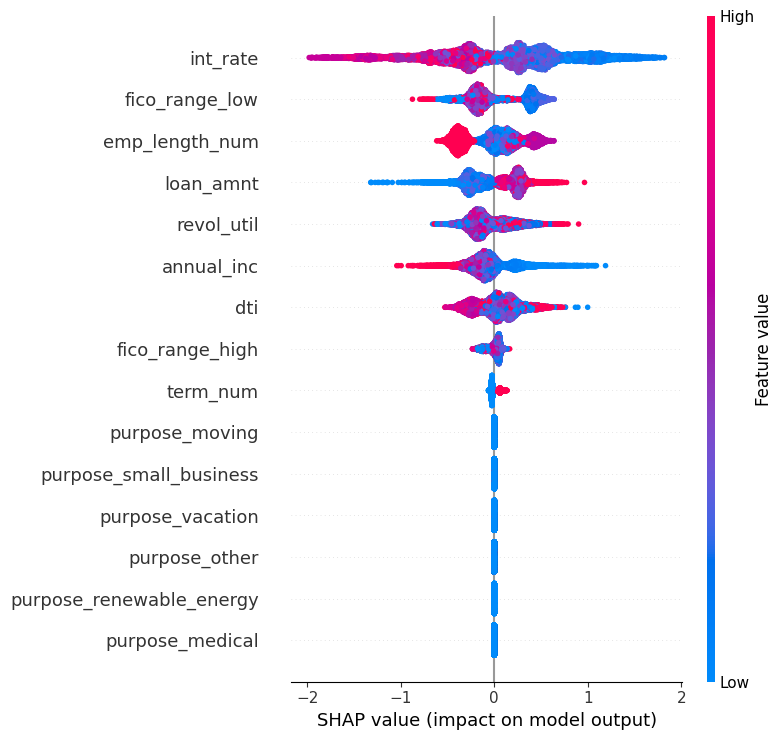

In [18]:
# Map OHE-expanded feature names to XGBoost importances (gain)
ohe = best_model.named_steps["pre"].transformers_[1][1] if len(cat_cols) else None
cat_names = list(ohe.get_feature_names_out(cat_cols)) if ohe is not None else []
feature_names = num_cols + cat_names

clf = best_model.named_steps["clf"]

# XGBoost built-in importances (gain) aligned to transformed columns
importances = pd.Series(clf.feature_importances_, index=feature_names).sort_values(ascending=False)
display(importances.head(25))


X_train_trans = best_model.named_steps["pre"].transform(X_train)
X_test_trans  = best_model.named_steps["pre"].transform(X_test)

# Densify if sparse
if hasattr(X_train_trans, "toarray"):
    X_train_trans = X_train_trans.toarray()
    X_test_trans  = X_test_trans.toarray()

# Use a small background set for performance
rng = np.random.RandomState(42)
bg_idx = rng.choice(X_train_trans.shape[0], size=min(1000, X_train_trans.shape[0]), replace=False)
background = X_train_trans[bg_idx]

explainer = shap.TreeExplainer(clf, data=background, feature_names=feature_names)
sv = explainer.shap_values(X_test_trans)  # for XGBoost binary, returns array (no list)
# Global summary: which features drive default risk most (by |SHAP|)
shap.summary_plot(sv, X_test_trans, feature_names=feature_names, max_display=15, show=True)


* **XGBoost gain importances**: Model relies most on **grade, subgrade, and interest rate**, then FICO, income, loan amount, verification, home ownership, and loan purpose.
* **SHAP plot**: Shows **directions** of impact:

  * Higher **interest rate, DTI, revol_util, loan amount, 60-month term** → higher risk
  * Higher **FICO, income, employment length** → lower risk
  * Some purposes (business, medical, vacation) slightly increase risk

**Reconciliation:** Gain shows *where trees split most*, SHAP shows *how values shift predictions*. Grade/subgrade overlap with int_rate/FICO, so SHAP emphasizes the continuous features.

**Implication:** If you want the model **before pricing is set**, remove grade/subgrade/int_rate (they leak info). If you want **post-booking monitoring**, keep them.

👉 In Conclusion: **Default risk rises with higher rate, higher debt, larger loan, long term, and certain purposes. It falls with higher credit score, higher income, and longer employment.**
